In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import csv
import nltk
import json       # since data is in json format, it's easier to convert from str to list/json readable format
import matplotlib.pyplot as plt

In [2]:
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

--2023-05-06 11:24:16--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv’

tmdb_5000_movies.cs 100%[===================>]   5.43M  8.48MB/s    in 0.6s    

2023-05-06 11:24:17 (8.48 MB/s) - ‘tmdb_5000_movies.csv’ saved [5698602/5698602]



In [3]:
movie_df = pd.read_csv('tmdb_5000_movies.csv')
movie_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
movie_df.genres.nunique()

1175

In [ ]:
movie_df.shape, movie_df.isna().values.any()

((4803, 20), True)

In [ ]:
movie_df.isna().sum()
new_df = movie_df.dropna()
movie_df.shape, new_df.shape

((4803, 20), (1493, 20))

In [ ]:
# vector_obj = TfidfVectorizer()
# XTrain = vector_obj.fit_transform(movie_df)
# Xtest = vector_obj.transform()
# movie_df.sample().genres

In [ ]:
movie_df.genres[0].split(',')[1]

' "name": "Action"}'

In [5]:
x = movie_df.iloc[0]        # at first location, movie records (other locations can also be used- 0 is row number we want to use)
movie_df.iloc[0].keywords
movie_df.iloc[0].genres
for i in movie_df.iloc[0].genres:
  m = json.loads(x['genres'])       # converts from str to json object type
  # print(m[0])
  # print(m[0]['name'])                 # now we can access data normally, m[0] returns dict and name returns the value of key 'name' in dict

In [6]:
j = json.loads(x['genres'])
' '.join(' '.join(record['name'].split()) for record in j)

'Action Adventure Fantasy Science Fiction'

In [7]:
def get_genres_and_keywords(movie_row):
  genre = json.loads(movie_row['genres'])
  genres = ' '.join(''.join(record['name'].split()) for record in genre)

  keyword = json.loads(movie_row['keywords'])
  keywords = ' '.join(''.join(record['name'].split()) for record in keyword)
  return f'{keywords} {genres}'

In [8]:
movie_df['string'] = movie_df.apply(get_genres_and_keywords, axis=1)
movie_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,string
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,cultureclash future spacewar spacecolony socie...
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,ocean drugabuse exoticisland eastindiatradingc...


In [9]:
vectorizer = TfidfVectorizer(max_features = 2500)
test_transform_matrix = vectorizer.fit_transform(movie_df.string)
test_transform_matrix

<4803x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 38972 stored elements in Compressed Sparse Row format>

In [10]:
movie_to_id = pd.Series(movie_df.index, index=movie_df['title'])
movie_to_id          # since test transform matrix stores it in vector form where the index will be used to get the movie's records and stuff, we need a series that has movie as index and a reference number(i.e. index) as values

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [11]:
checking_query = movie_to_id['Avatar']     # we can choose any movie but this is for testing and training purposes
test_query_matrix = test_transform_matrix[checking_query]
checking_query

0

In [12]:
test_query_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [13]:
similarity_scores = cosine_similarity(test_query_matrix, test_transform_matrix)
similarity_scores_euclidean = euclidean_distances(test_query_matrix, test_transform_matrix)
# checking how similar the test query and records in the actual matrix (kinda database) are

In [14]:
similarity_scores = similarity_scores.flatten()     # since our score matrix is 1d anyway just shorten it 

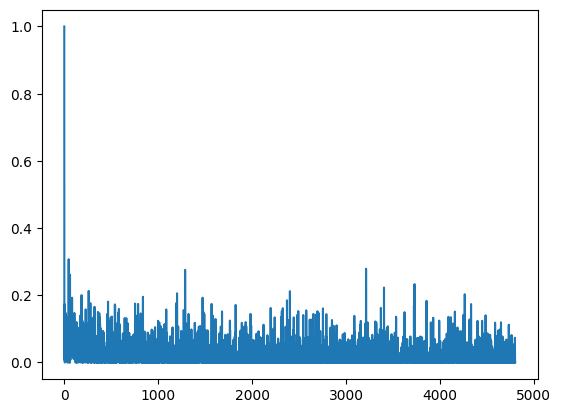

In [15]:
plt.plot(similarity_scores)

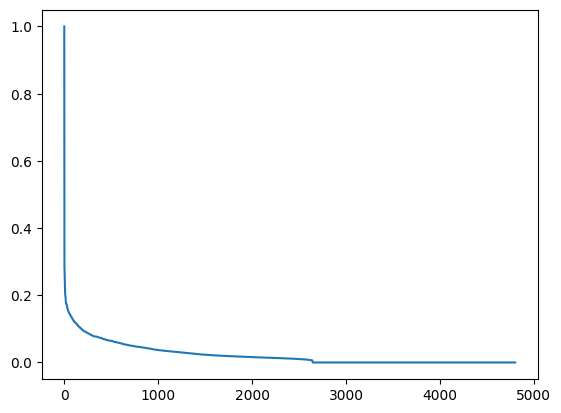

In [ ]:
plt.plot(similarity_scores[(-similarity_scores).argsort()])
# arg sort, returns a sorted array according to argument given, in this case, it is similarity scores (negative of that, meaning reverse order sorting)
# which order the movies are ranked in, if we sort according to their similarity scores

In [16]:
# getting top 5 matches and sorting and plotting
recommended_movie_ids = (-similarity_scores).argsort()[1:6]
title_of_movies = movie_to_id.iloc[recommended_movie_ids]
title_of_movies

title
Star Trek Into Darkness      47
Barbarella                 3214
A Monster in Paris         1287
Jupiter Ascending            61
Cargo                      3730
dtype: int64

In [ ]:
idx = movie_to_id['Spectre']
# if type(idx) == pd.Series:
#   idx = idx.iloc[0]
idx

2

In [ ]:
movie_df['title']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: title, Length: 4803, dtype: object

In [17]:
# making a function for retrieving data according to our input in a function, for obtaining only 5 movies
def get_movies(movie):
  movie_id = movie_to_id[movie]
  if type(movie_id) == pd.Series:
    movie_id = movie_to_id.iloc(movie_id)

  training_query = test_transform_matrix[movie_id]
  similar_scores = cosine_similarity(training_query, test_transform_matrix)
  similar_scores = similar_scores.flatten()
  recommended_idx = (-similar_scores).argsort()[1:6]

  return movie_df['title'].iloc[recommended_idx]     # iloc gives whole record according to id, movie_df['title'] gives the title from that record inside main dataframe i.e. movie_df here

In [18]:
movie_name = input('enter name of movie you have recently watched')
print(f'movies similar to {movie_name}: ')
print(get_movies(movie_name))

enter name of movie you have recently watchedJohn Carter
movies similar to John Carter: 
3904                       Spaced Invaders
373                        Mission to Mars
205     Sherlock Holmes: A Game of Shadows
752                    My Favorite Martian
3405            Stargate: The Ark of Truth
Name: title, dtype: object


In [19]:
# second test
movie_name = input('enter name of movie you have recently watched')
print(f'movies similar to {movie_name}: ')
print(get_movies(movie_name), type(get_movies(movie_name)))

enter name of movie you have recently watchedSpectre
movies similar to Spectre: 
11      Quantum of Solace
29                Skyfall
3285             Restless
2644            Ong Bak 2
751             Duplicity
Name: title, dtype: object <class 'pandas.core.series.Series'>


In [ ]:
len(movie_df)

4803

In [ ]:
def split_dataframe(df, chunk_size = 480): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1          # in this case, 4803//480 +1 : +1 because the last 3 records also need to be taken into account
    for i in range(num_chunks):             # in range 11
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])    # df[0*48: 1*48] and so on, basically increments of 48
    return chunks

In [ ]:
x = split_dataframe(movie_df)
x[0].shape
type(x[0])

pandas.core.frame.DataFrame

In [ ]:
# example to understand working of skf

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


In [ ]:
trial = np.array(split_dataframe(movie_df))

<ipython-input-30-545030a1bf7c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trial = np.array(split_dataframe(movie_df))


In [ ]:
vectorizer = TfidfVectorizer(max_features = 2500)
X = vectorizer.fit_transform(movie_df.string)
y = (-similarity_scores).argsort()[1:21]
type(x), type(y), y.shape, x.shape

(pandas.core.series.Series, numpy.ndarray, (20,), (20,))

In [20]:
new_df = movie_df.drop(['genres', 'homepage', 'keywords', 'original_title', 'overview', 'production_companies', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'production_countries', 'original_language'], axis=1)
new_df.head(1)
new_df = new_df.dropna()
new_df.head(1)

,budget,id,popularity,revenue,runtime,vote_average,vote_count,string
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,cultureclash future spacewar spacecolony socie...


In [21]:
# getting results from Linear Regression model first (Logistic regression requires data to be grouped and encoded first)

# Label encoding
Label = LabelEncoder()
twoD_array = movie_df[['original_language']]
Label.fit(twoD_array)
# new_df.original_language = Label.transform(twoD_array)

# linear regression model
Lmodel = LinearRegression()
input_features = new_df.drop(['string'], axis=1)
vectorizer = TfidfVectorizer(max_features = 2500)
target_var = vectorizer.fit_transform(new_df.string).toarray().astype(np.float32)      
# linear regression model does not accept csr matrixes(output of vectorizer.fit_transform is csr_matrix) by default, so convert into an array and further into a float value

input_features_train, input_features_test, target_var_train, target_var_test = train_test_split(input_features, target_var, test_size=0.5)
Lmodel.fit(input_features_train, target_var_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearRegression()

In [22]:
intercept = Lmodel.intercept_[0]
intercept

model_pred = Lmodel.predict(input_features_train)
pred_df = pd.DataFrame(input_features_test)
pred_df['predicted_movie'] = model_pred.reshape(-1,1)[:2401]
pred_df.sort_values('predicted_movie', ascending=False)

,budget,id,popularity,revenue,runtime,vote_average,vote_count,predicted_movie
2750,13200000,136835,24.656068,53830415,83.0,5.6,181,0.207844
1153,40000000,240832,115.241998,126546825,89.0,6.3,5878,0.117241
3085,0,9613,6.948401,0,98.0,6.4,168,0.081031
4032,2500000,20764,4.624691,107559,90.0,6.0,40,0.050110
1790,26000000,134,39.742009,71868327,106.0,7.3,1112,0.049099
...,...,...,...,...,...,...,...,...
1315,57000000,12508,11.608150,16991902,105.0,6.0,190,-0.027163
4554,0,322194,0.397323,0,110.0,3.4,4,-0.033433
2484,16000000,1090,19.890428,18564088,100.0,6.8,378,-0.047385
791,58000000,257445,45.351617,158162788,103.0,6.2,995,-0.066991


In [23]:
movie_df.loc[1860].title, movie_df.loc[534].title, movie_df.loc[3617].title

('Kiss of the Dragon', 'Bandits', 'The Forsaken')

In [ ]:
#cross-validation procedure- requires further modifications for logistic regression to work
skf = StratifiedKFold(n_splits=10)
vectorizer = TfidfVectorizer(max_features = 2500)
X = vectorizer.fit_transform(movie_df.string)
y = similarity_scores
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate the model
    model = LogisticRegression()

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the performance of the model on the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")


In [25]:
threshold = 0.2
similarity_scores_categorical = np.where(similarity_scores >= threshold, 1, 0)

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5)
X = vectorizer.fit_transform(movie_df.string)
y = similarity_scores_categorical

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Instantiate the model
    model = LinearRegression()

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted values to categorical values or bins
    y_pred_categorical = np.where(y_pred >= threshold, 1, 0)

    # Evaluate the performance of the model on the test set
    accuracy = accuracy_score(y_test, y_pred_categorical)
    print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.93
Accuracy: 0.96
Accuracy: 0.96
Accuracy: 0.97
Accuracy: 0.98


In [ ]:
pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


In [26]:
pd.set_option('display.max_colwidth', None)
movie_df.loc[movie_df['title']=='Spectre'].string

2    spy basedonnovel secretagent sequel mi6 britishsecretservice unitedkingdom Action Adventure Crime
Name: string, dtype: object

In [ ]:
n = 1601
def get_movies_check(movie):
  movie_id = movie_to_id[movie]
  if type(movie_id) == pd.Series:
    movie_id = movie_to_id.iloc(movie_id)

  for g, df in movie_df.groupby(np.arange(len(movie_df)) // n):
    vectorizer = TfidfVectorizer(max_features = 2500)
    test_transform_matrix = vectorizer.fit_transform(df.string)
    training_query = test_transform_matrix[movie_id]
    similar_scores = cosine_similarity(training_query, test_transform_matrix)
    similar_scores = similar_scores.flatten()
    recommended_idx = (-similar_scores).argsort()[1:3]
    print(movie_df['string'].iloc[recommended_idx]) 
  
  print('\n')
  for i in movie_df['string'].iloc[recommended_idx]:
    vectorizer = TfidfVectorizer()
    vectorized_input_movie = vectorizer.fit_transform([movie])
    vectorized_output_movie = vectorizer.fit_transform([i])
    # print(i)
    print(cosine_similarity(vectorized_input_movie, vectorized_output_movie))        # returns matrix compatibility error

movie = input("enter movie to get recommendations: ")
get_movies_check(movie)

In [27]:
movie_df.vote_average.sample(1)

749    7.0
Name: vote_average, dtype: float64

In [28]:
# Create a mapping of movie titles to movie ids
movie_to_id = dict(zip(movie_df['title'], movie_df['id']))
movie_df.dropna()

vectorizer = TfidfVectorizer(stop_words='english', max_features=2500)
tfidf_matrix = vectorizer.fit_transform(movie_df['overview'].values.astype(str))    # normal transform won't work due to the values not being unicode or byte-type

# pairwise cosine similarities between all the movies
cosine_sim = cosine_similarity(tfidf_matrix)


regressor = LinearRegression()
X = tfidf_matrix.toarray()
y = movie_df['vote_average'].values           # to rank them according to rating
regressor.fit(X, y)

def get_similar_movies(movie_title):
    # Get the movie id for the given title
    movie_id = movie_to_id[movie_title]
    # index of the movie in the cosine similarity matrix
    movie_index = np.where(movie_df['id'] == movie_id)[0][0]
    #cosine similarities between the given movie and all the other movies
    sim_scores = cosine_sim[movie_index]
    # Use the linear regression model to predict the ratings for all the movies
    predicted_ratings = regressor.predict(X)
    # Cosine similarities between the predicted ratings and the actual ratings, flatten-1d
    rating_sim_scores = cosine_similarity(predicted_ratings.reshape(1, -1), y.reshape(1, -1)).flatten()
    # combined simiarity score of all records
    combined_sim_scores = 0.5 * sim_scores + 0.5 * rating_sim_scores
    # top 10 similar movies
    similar_indices = np.argsort(combined_sim_scores)[-10:]
    similar_movies = [(movie_df['title'].iloc[i], combined_sim_scores[i]) for i in similar_indices[::-1]]      #list comprehension
    return similar_movies

# testcase
similar_movies = get_similar_movies('Spectre')
print(similar_movies)


[('Spectre', 0.9957948655061213), ('Never Say Never Again', 0.6767436250993226), ('Thunderball', 0.6536018886922976), ('Quantum of Solace', 0.6437455093683566), ('From Russia with Love', 0.6314317575161232), ('Safe Haven', 0.6266631423993871), ('Skyfall', 0.6115794515751032), ('Dr. No', 0.6071833176290554), ('Romeo Must Die', 0.6035481284845865), ('The Man with the Golden Gun', 0.602681229405575)]


In [ ]:
# Use StratifiedKFold for cross-validation
X = tfidf_matrix.toarray()
y = movie_df['vote_average'].values           # to rank them according to rating

skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model on the training set
    regressor.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = regressor.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

ValueError: ignored